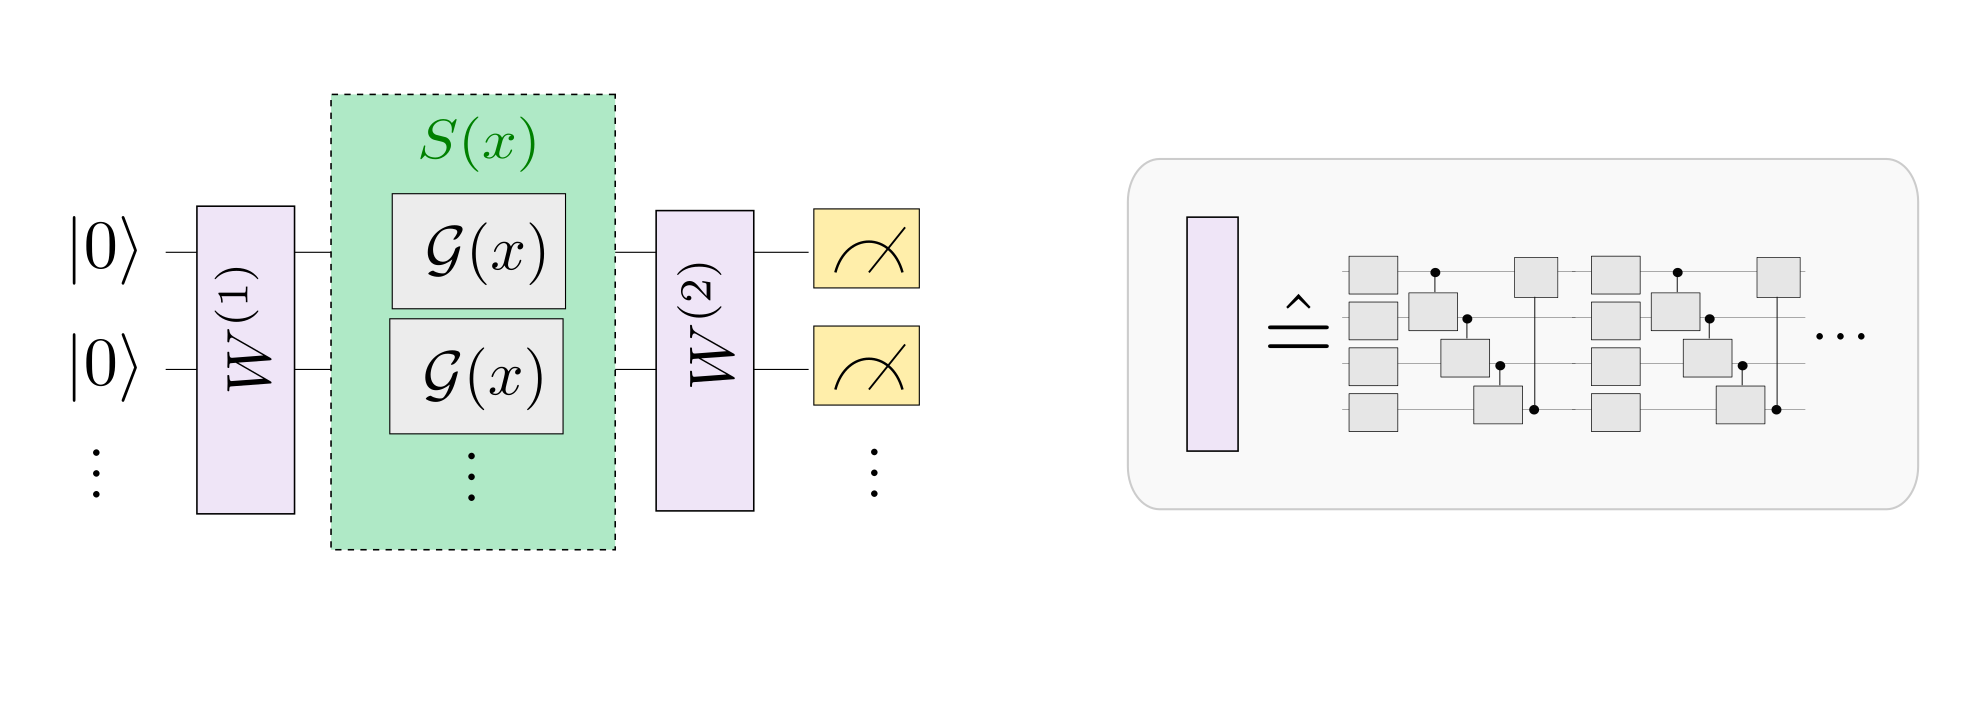

In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
from pennylane import numpy as np
from pennylane.templates import StronglyEntanglingLayers
numb_layer = 4
numb_qubit = 3

def loss(target, prediction):
  loss=0
  for t,p in zip(target, prediction):
    loss += 0.5*(t-p)**2
  loss = loss/len(target)
  return loss

dev = qml.device('default.qubit',wires=4)

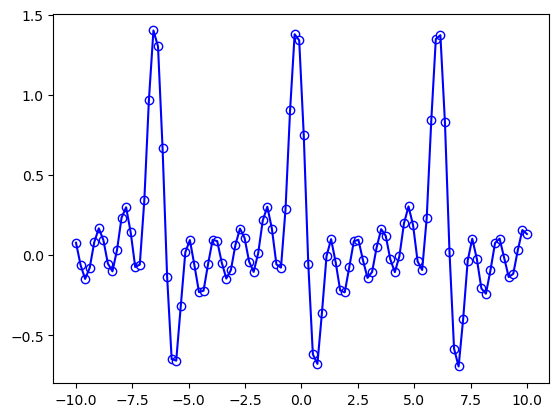

In [2]:
degree = 5
c0 = 0.1
cn = [0.1+0.1j]*degree
scaling=1

def TargetFunc(x):
  res = c0
  for i,ci in enumerate(cn,start=1):
    expnt = np.complex128(scaling*i*x*1j)
    res1 = ci*np.exp(expnt)
    res2 = np.conjugate(res1)
    res += res1+res2
  return np.real(res)

x = np.linspace(-10,10,100,requires_grad=False)
ytarget = np.array([TargetFunc(X) for X in x],requires_grad=False)
plt.scatter(x,ytarget,facecolor='white',edgecolor='blue')
plt.plot(x,ytarget,c='blue')

plt.show()

In [3]:
r = degree
dev = qml.device('default.qubit',wires=r)

def S(x):
    for i in range(r):
        qml.RX(scaling*x, wires = i)

def W(theta):
    StronglyEntanglingLayers(theta,wires = range(r))

@qml.qnode(dev)
def QuModel(weights,x):
    W(weights[0])
    S(x)
    W(weights[1])
    return qml.expval(qml.PauliZ(wires=0))

Wlayer = 3
Weights = 2*np.pi*np.random.random(size=(2,Wlayer,r,3))


In [4]:
def CostF(weights,x,y):
    prediction = [QuModel(weights,X) for X in x]
    return loss(y,prediction)

MaxStep = 150
opt = qml.AdagradOptimizer(0.6)
BatchSize = 16
cost = [CostF(Weights,x,ytarget)]

for step in range(MaxStep):
    BatchIndex = np.random.randint(0,len(x),BatchSize)
    xBatch = x[BatchIndex]
    yBatch = ytarget[BatchIndex]
    Weights = opt.step(CostF,Weights,xBatch,yBatch)[0]
    cst = CostF(Weights,x,ytarget)
    cost.append(cst)
    if (step+1)%10 == 0:
        print('cost at step {0:3}: {1}'.format(step+1,cst))


cost at step  10: 0.09037351015121754
cost at step  20: 0.043493571312984855
cost at step  30: 0.025272367810720193
cost at step  40: 0.028074987272020003
cost at step  50: 0.020321508810957827
cost at step  60: 0.02022931331975637
cost at step  70: 0.02329995219111531
cost at step  80: 0.012824147943362216
cost at step  90: 0.012810473655861214
cost at step 100: 0.015169398329051563
cost at step 110: 0.01382544223056504
cost at step 120: 0.011242027184467008
cost at step 130: 0.009037455013203171
cost at step 140: 0.00956144165525598
cost at step 150: 0.009739193063752885


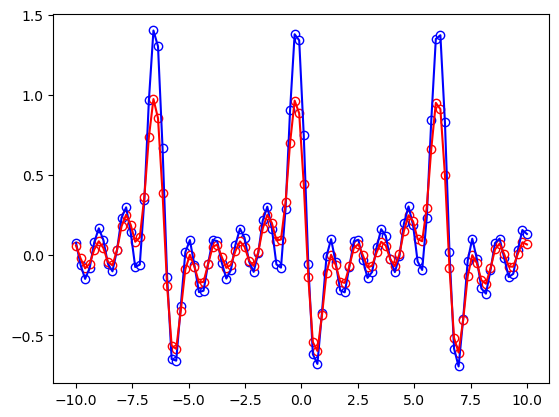

In [5]:

prediction =[QuModel(Weights,X)for X in x]
plt.scatter(x,ytarget,facecolor='white',edgecolor='blue')
plt.plot(x,ytarget,c='blue')
plt.scatter(x,prediction,facecolor='white',edgecolor='red')
plt.plot(x,prediction,c='red')

plt.show()


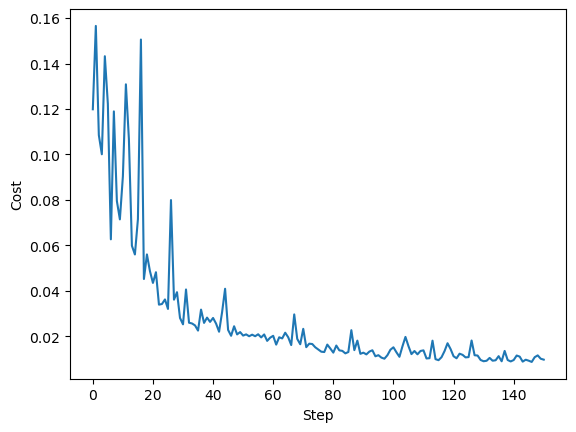

In [6]:
plt.plot(range(len(cost)),cost)
plt.ylabel('Cost')
plt.xlabel('Step')
plt.show()